## Aprendizaje no supervisado: Clustering

#### Maximiliano Vides

### Objetivos

En este practico se explorar ́an diferentes soluciones de clustering, para desarrollar las capacidades de analisis de
soluciones de clustering. Es preferible que los conjuntos de datos con los que trabajar sean propios, ya que de esta

forma podran aplicar su conocimiento del dominio en la interpretacion de las diferentes soluciones. Alternativamente, pueden usar conjuntos de datos de los ejemplos de la materia.

En los mismos, hacer una breve discusion del problema y explicar como puede ser  ́util usar tecnicas de clustering.

In [1]:
from sklearn.datasets import load_files 

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

from __future__ import print_function

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib
from sklearn.cluster import KMeans

# Dataset

Usaremos un dataset extraido de https://arxiv.org/ que consiste en datos de 10000 papers de la sección de matemática de dicha página que fueron descargados utilizando la Arxiv API (https://arxiv.org/help/api/index).
De este dataset guardado en formato Json, contiene metadatos de cada artículo, como titulo, resumen, autores, link del artículo, distitnos tags entre otros, de los cuales vamos a utilizar solamente los datos correspondientes a los resúmenes y titulos para intentar hacer un clustering de los papers en relación a las palabras en común.

In [2]:
import json
with open('data.json') as f:
    datamath = json.load(f,encoding="UTF-8")

In [3]:
len(datamath["entries"])

10000

Como ejemplo veamos la primera entrada del dataset:

In [4]:
datamath["entries"][0]

{'id': 'http://arxiv.org/abs/math/0409250v3',
 'guidislink': True,
 'link': 'http://arxiv.org/abs/math/0409250v3',
 'updated': '2006-01-28T08:56:59Z',
 'updated_parsed': [2006, 1, 28, 8, 56, 59, 5, 28, 0],
 'published': '2004-09-15T14:01:51Z',
 'published_parsed': [2004, 9, 15, 14, 1, 51, 2, 259, 0],
 'title': 'Von Neumann coordinatization is not first-order',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': 'http://export.arxiv.org/api/query?search_query=cat:math*&start=0&max_results=10000',
  'value': 'Von Neumann coordinatization is not first-order'},
 'summary': 'A lattice L is coordinatizable, if it is isomorphic to the lattice L(R) of\nprincipal right ideals of some von Neumann regular ring R. This forces L to be\ncomplemented modular. All known sufficient conditions for coordinatizability,\ndue first to J. von Neumann, then to B. Jonsson, are first-order. Nevertheless,\nwe prove that coordinatizability of lattices is not first-order, by finding a\nnon-coordi

In [5]:
len(datamath["entries"])

10000

Ahora vamos a extraer solamente los datos correspondientes al título,resumen de cada entrada para hacer el clustering y los tags para luego implementar una métrica basada en testigos.

In [6]:
titles = [datamath["entries"][i]["title"] for i in range(len(datamath["entries"]))]
len(titles)


10000

In [7]:
summaries = [datamath["entries"][i]["summary"] for i in range(len(datamath["entries"]))]
len(summaries)

10000

In [8]:
authors=[]
for j in range(len(datamath["entries"])):
 authors.append(set())
 for i in range(len(datamath["entries"][j]["authors"])):
  authors[j].add(datamath["entries"][j]["authors"][i]["name"])

In [9]:
tags=[]
for j in range(len(datamath["entries"])):
 tags.append(set())
 for i in range(len(datamath["entries"][j]["tags"])):
  tags[j].add(datamath["entries"][j]["tags"][i]["term"])

In [10]:
titles[4760]

'Filtrations and Homological degrees of FI-modules'

In [11]:
summaries[4760]

'Let $k$ be a commutative Noetherian ring. In this paper we consider filtered\nmodules of the category FI firstly introduced by Nagpal. We show that a\nfinitely generated FI-module $V$ is filtered if and only if its higher\nhomologies all vanish, and if and only if a certain homology vanishes. Using\nthis homological characterization, we characterize finitely generated\nFI-modules $V$ whose projective dimension is finite, and describe an upper\nbound for it. Furthermore, we give a new proof for the fact that $V$ induces a\nfinite complex of filtered modules, and use it as well as a result of Church\nand Ellenberg to obtain another upper bound for homological degrees of $V$.'

In [12]:
authors[4760]

{'Liping Li', 'Nina Yu'}

In [13]:
tags[4760]

{'math.KT', 'math.RA', 'math.RT'}

A continuación definimos un tokenizer para poder aplicar el TfidfVectorizer

In [14]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
         if token[0] not in ["\\","'","-"]:
          if len(token)>2: #eliminar palabras cortas
            filtered_tokens.append(token)
    return filtered_tokens



In [15]:
# e.g.:
from nltk.tokenize import word_tokenize
text = summaries[1200]
tokens = tokenize_only(text)
print(tokens)

['the', 'first', 'part', 'this', 'article', 'devoted', 'brief', 'review', 'the', 'results', 'about', 'representation', 'theory', 'the', 'spin', 'group', 'spin', 'from', 'the', 'point', 'view', 'clifford', 'analysis', 'the', 'second', 'part', 'are', 'interested', 'clifford-valued', 'functions', 'and', 'wavelets', 'the', 'sphere', 'the', 'connection', 'representations', 'spin', 'and', 'the', 'concept', 'diffusive', 'wavelets', 'leads', 'naturally', 'investigations', 'modified', 'diffusion', 'equation', 'the', 'sphere', 'that', 'makes', 'use', 'the', 'gamma', 'operator', 'will', 'achieve', 'obtain', 'clifford-valued', 'diffusion', 'wavelets', 'with', 'respect', 'modified', 'diffusion', 'operator', 'since', 'are', 'able', 'characterize', 'all', 'representations', 'spin', 'and', 'even', 'obtain', 'all', 'eigenvectors', 'the', 'representation', 'regarded', 'casimir', 'operator', 'representation', 'spaces', 'seems', 'appropriate', 'look', 'functions', 'spin', 'directly', 'concerning', 'this',

In [16]:
totalvocab_tokenized = []

for i in summaries:
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [17]:
print('Hay en total ' + str(len(totalvocab_tokenized)) + ' tokens \n')
len(totalvocab_tokenized)
print (totalvocab_tokenized[0:100])

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_tokenized)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

Hay en total 705470 tokens 

['lattice', 'coordinatizable', 'isomorphic', 'the', 'lattice', 'principal', 'right', 'ideals', 'some', 'von', 'neumann', 'regular', 'ring', 'this', 'forces', 'complemented', 'modular', 'all', 'known', 'sufficient', 'conditions', 'for', 'coordinatizability', 'due', 'first', 'von', 'neumann', 'then', 'jonsson', 'are', 'first-order', 'nevertheless', 'prove', 'that', 'coordinatizability', 'lattices', 'not', 'first-order', 'finding', 'non-coordinatizable', 'lattice', 'with', 'coordinatizable', 'countable', 'elementary', 'extension', 'this', 'solves', 'problem', 'jonsson', 'also', 'prove', 'that', 'there', 'l\\_', 'infinity', 'infinity', 'statement', 'equivalent', 'coordinatizability', 'furthermore', 'the', 'class', 'coordinatizable', 'lattices', 'not', 'closed', 'under', 'countable', 'directed', 'unions', 'this', 'solves', 'another', 'problem', 'jonsson', 'from', 'this', 'expository', 'paper', 'which', 'explain', 'how', 'core', 'mathematics', 'particularly', 'ab

Finalmente utilizamos TfidfVectorizer para representar los resumenes npumericamente y poder usar el algoritmo k-means para hacer el clustering.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,strip_accents="unicode", #max_features=400000,
                                 min_df=4, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_only, 
                                   ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(summaries) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

(10000, 20653)


Revisamos los términos extraidos del dataset

In [19]:
terms[200:350]

['abstract theory',
 'abstract version',
 'abstracting',
 'abstraction',
 'abstractly',
 'academic',
 'academy',
 'academy sciences',
 'accept',
 'acceptable',
 'accepted',
 'accepting',
 'access',
 'accessible',
 'accessible categories',
 'accessible students',
 'accessible students familiar',
 'accommodate',
 'accompanied',
 'accomplish',
 'accomplished',
 'accomplishments',
 'accordance',
 'according',
 'according certain',
 'accordingly',
 'account',
 'accounts',
 'accumulate',
 'accumulation',
 'accumulation points',
 'accuracy',
 'accurate',
 'accurately',
 'achieve',
 'achieved',
 'achievement',
 'achievements',
 'ackermann',
 'acquainted',
 'acquired',
 'acquires',
 'act',
 'act properly',
 'acta',
 'acta eruditorum',
 'acted',
 'acting',
 'acting freely',
 'acting functions',
 'acting l^2',
 'acting sections',
 'acting space',
 'action',
 'action associated',
 'action compact',
 'action compact lie',
 'action compact quantum',
 'action countable',
 'action discrete',
 'action 

### Métrica basada en testigos

Definimos una lista con aquellos artícluos que compartan los mismos tags y tengan los mismos autores, que en principio deberian estar más asociados y por lo tanto aparecen en el mismo cluster.

In [20]:
equaltags=[]
for i in range(len(tags)):
 if len(tags[i])>2:
  for j in range(i+1,len(tags)):
   if tags[i]==tags[j]:
    if authors[i]==authors[j]:
     equaltags.append((i,j))

In [21]:
len(equaltags)

962

In [22]:
def testigos(equaltags, data):
    eq = []
    for (a, b) in equaltags:
        if data[a] != data[b]:
            eq.append((a, b))
    print('Hay %i coincidencias de %i dadas sobre testigos iguales' % (len(equaltags) - len(eq), len(equaltags)))

Ahora vamos a evaluar el rendimiento del clustering con k-means para distintos valores de $k$, utilizando la silhouette score, la inercia y la métrica testigo implementada.

In [24]:
from sklearn.metrics import silhouette_score
range_n_clusters=range(2,20,1)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(tfidf_matrix)
    centers = clusterer.cluster_centers_
    clusters = clusterer.labels_.tolist()

    score = silhouette_score(tfidf_matrix, preds, metric='cosine')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    #print("Inertia is {})".clusterer.inertia_)
    testigos(equaltags, clusters)
    for i in range(n_clusters):
     print ('El cluster %i tiene %i elementos' % (i, clusters.count(i)))
    print("=" *40)
#plot it
#fig = plt.figure(figsize=(15, 5))
#plt.plot(range(2, 500, 10), score)
#plt.grid(True)
#plt.title('Elbow curve')

For n_clusters = 2, silhouette score is 0.005428102365812775)
Hay 789 coincidencias de 962 dadas sobre testigos iguales
El cluster 0 tiene 6284 elementos
El cluster 1 tiene 3716 elementos
For n_clusters = 3, silhouette score is 0.004931251868846174)
Hay 568 coincidencias de 962 dadas sobre testigos iguales
El cluster 0 tiene 4188 elementos
El cluster 1 tiene 4793 elementos
El cluster 2 tiene 1019 elementos
For n_clusters = 4, silhouette score is 0.005434696752650945)
Hay 548 coincidencias de 962 dadas sobre testigos iguales
El cluster 0 tiene 850 elementos
El cluster 1 tiene 2079 elementos
El cluster 2 tiene 4478 elementos
El cluster 3 tiene 2593 elementos
For n_clusters = 5, silhouette score is 0.005968842707982929)
Hay 545 coincidencias de 962 dadas sobre testigos iguales
El cluster 0 tiene 2454 elementos
El cluster 1 tiene 2075 elementos
El cluster 2 tiene 3880 elementos
El cluster 3 tiene 717 elementos
El cluster 4 tiene 874 elementos
For n_clusters = 6, silhouette score is 0.00713

For n_clusters = 19, silhouette score is 0.012119012202469389)
Hay 355 coincidencias de 962 dadas sobre testigos iguales
El cluster 0 tiene 487 elementos
El cluster 1 tiene 434 elementos
El cluster 2 tiene 161 elementos
El cluster 3 tiene 211 elementos
El cluster 4 tiene 716 elementos
El cluster 5 tiene 668 elementos
El cluster 6 tiene 317 elementos
El cluster 7 tiene 2333 elementos
El cluster 8 tiene 534 elementos
El cluster 9 tiene 572 elementos
El cluster 10 tiene 887 elementos
El cluster 11 tiene 361 elementos
El cluster 12 tiene 375 elementos
El cluster 13 tiene 705 elementos
El cluster 14 tiene 27 elementos
El cluster 15 tiene 219 elementos
El cluster 16 tiene 728 elementos
El cluster 17 tiene 149 elementos
El cluster 18 tiene 116 elementos


In [25]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

wcse = []
for k in range(1, 1000, 50):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=10000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(tfidf_matrix) # where X is my data
    wcse.append(kmeans_model.inertia_)

#plot it
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 1000, 50), wcse)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5,1,'Elbow curve')

Text(0.5,1,'Elbow curve')

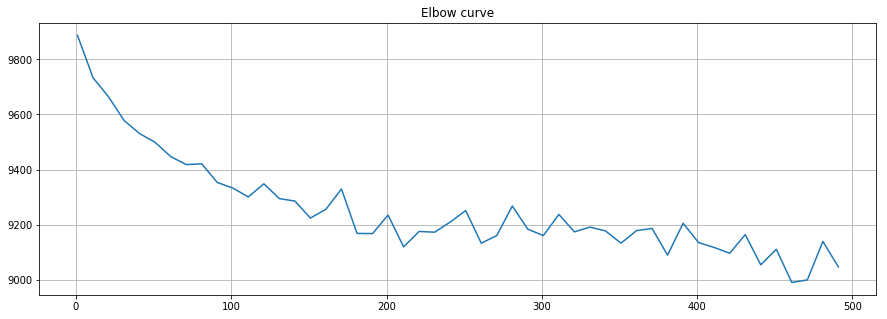

In [26]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

wcse = []
for k in range(1, 500, 10):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=10000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(tfidf_matrix) # where X is my data
    wcse.append(kmeans_model.inertia_)

#plot it
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 500, 10), wcse)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5,1,'Elbow curve')

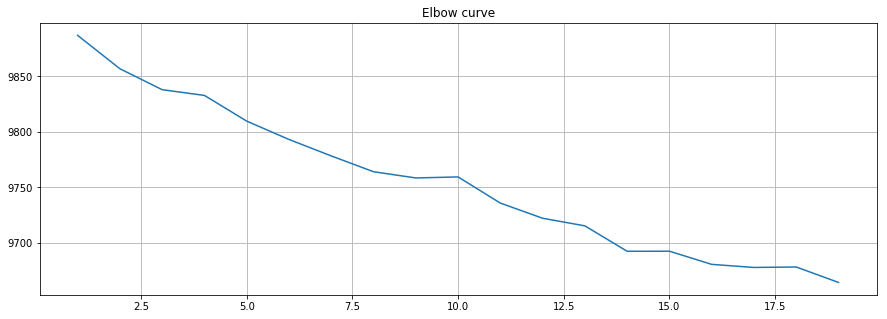

In [27]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

wcse = []
for k in range(1, 20, 1):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, 
                         init_size=10000, batch_size=10000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(tfidf_matrix) # where X is my data
    wcse.append(kmeans_model.inertia_)

#plot it
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 20, 1), wcse)
plt.grid(True)
plt.title('Elbow curve')

Si bien ninguna de las métricas nos provee una forma univoca de elegir un número de clusters óptimo, para hacer un análisis mas profundo tomaremos el valor $k=8$.

In [28]:
from sklearn.cluster import KMeans

num_clusters = 8

km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Vemos la cantidad de elementos en cada cluster

In [29]:
# Recuento del número de elementos en cada cluster
for i in range(num_clusters):
    print ('El cluster %i tiene %i elementos' % (i, clusters.count(i)))

El cluster 0 tiene 1051 elementos
El cluster 1 tiene 913 elementos
El cluster 2 tiene 122 elementos
El cluster 3 tiene 3745 elementos
El cluster 4 tiene 720 elementos
El cluster 5 tiene 1426 elementos
El cluster 6 tiene 1195 elementos
El cluster 7 tiene 828 elementos


In [30]:
abst = { 'title': titles, 'summary': summaries, 'cluster': clusters }
frame = pd.DataFrame(abst, columns = ['title',"cluster"])

In [31]:
frame[1:20]

,title,cluster
1,Analysis in J_2,3
2,From objects to diagrams for ranges of functors,3
3,A non-coordinatizable sectionally complemented modular lattice with a\n large Jónsson four-frame,3
4,Gelfand spectra and Wallman compactifications,7
5,Derived categories and syzygies,1
6,"Notes on A-infinity algebras, A-infinity categories and non-commutative\n geometry. I",1
7,Right Bousfield Localization and Operadic Algebras,7
8,The magnitude of metric spaces,0
9,Monotone-light factorizations in coarse geometry,0
10,Strong algebraization of fixed point properties,0


Ahora veremos los términos que determinan cada uno de los clusters para tratar de caracterizarlos

In [48]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]     
        
for i in range(num_clusters):
    print("*** Cluster %d:" % i, end='\n\n')
    
    print("WORDS /// ", end='')
    
    for ind in order_centroids[i, :30]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=' / ')
    print() #add whitespace
    print("=" *100) #add whitespace
    
    #print("TITLES /// ", end='')
    #for title in frame.loc[i]['title'].values.tolist():
    #    print(' %s / ' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()        
        

Top terms per cluster:

*** Cluster 0:

WORDS ///  space /  spaces /  metric /  topological /  compact /  continuous /  prove /  sets /  metric /  property /  metric /  set /  banach /  locally /  results /  topology /  finite /  countable /  result /  hausdorff /  theorem /  properties /  paper /  study /  closed /  open /  functions /  maps /  borel /  subsets / 


*** Cluster 1:

WORDS ///  algebras /  algebra /  homology /  cohomology /  lie /  hochschild /  cyclic /  complex /  theory /  hopf /  poisson /  structure /  ring /  algebraic /  k-theory /  homotopy /  graded /  cyclic /  groups /  hochschild /  lie /  topological /  operad /  prove /  construction /  paper /  study /  compute /  associated /  commutative / 


*** Cluster 2:

WORDS ///  fuzzy /  intuitionistic /  intuitionistic /  soft /  sets /  fuzzy /  neutrosophic /  fuzzy /  properties /  set /  introduced /  chapter /  ideals /  concept /  paper /  characterizations /  interval /  notion /  models /  using /  fuzz

A tráves de un wordcloud pueden verse mejor los términos

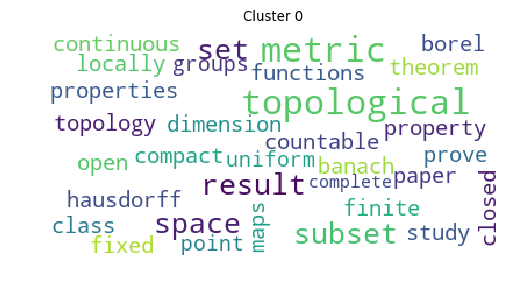

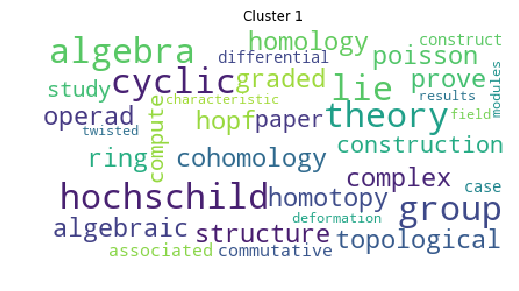

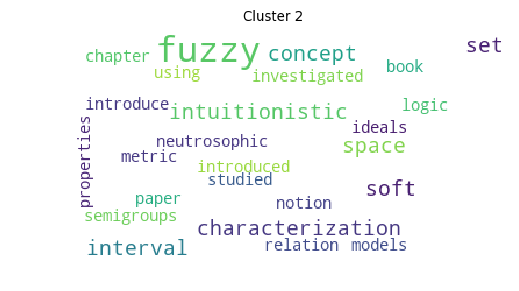

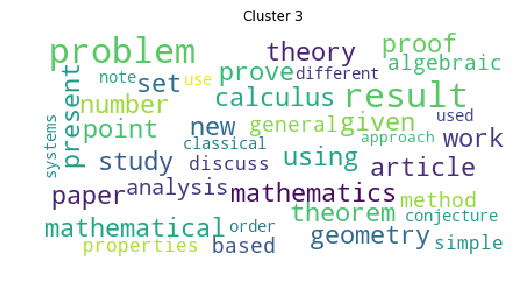

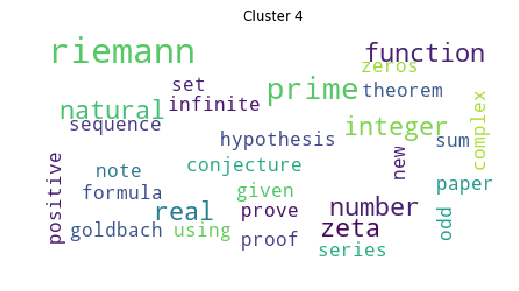

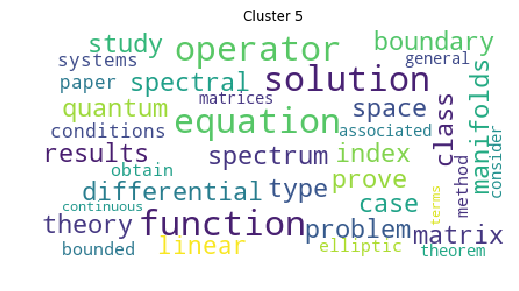

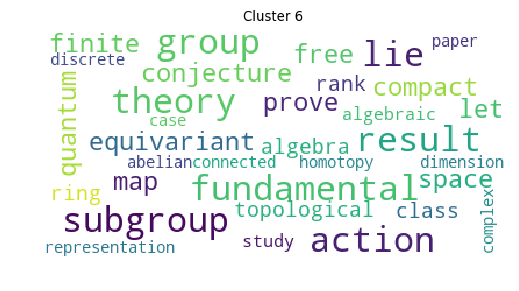

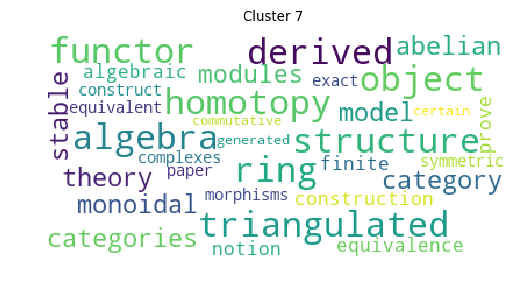

In [33]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud

mpl.rcParams['figure.figsize']=(6.0,4.0)    #(6.0,4.0)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size']=8              #10 
mpl.rcParams['figure.subplot.bottom']=.1 

order_centroids = km.cluster_centers_.argsort()[:, ::-1]     
        
for i in range(num_clusters):
 data=""
 for ind in order_centroids[i, :40]:
  data = data + " " + str(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])

 wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=30, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.figure(1)
 plt.title("Cluster %s" %i)
 plt.imshow(wordcloud)
 plt.axis('off')
 plt.show()


A partir de estos datos y observando los títulos de algunos de los artículos de cada cluster podemos tratar de interpretar cada uno de ellos.

### Cluster 0 

Las palabras principales indican que en este cluster hay más articulos sobre espacios métricos y topologia.

In [34]:
frame[frame["cluster"]==0].sample(10)

,title,cluster
3369,The Full Pythagorean Theorem,0
7143,"A dual identity based symbolic understanding of the Godel's\n incompleteness theorems, P-NP pro...",0
3198,"From quaternions to cosmology: spaces of constant curvature, ca.\n 1873-1925",0
2741,Absolutely minimal Lipschitz extension of tree-valued mappings,0
6366,Nonstandard Vector Space with a Metric and Its Topological Structure,0
2277,On the asymptotic magnitude of subsets of Euclidean space,0
2814,Large inductive dimension of the Smirnov remainder,0
5177,Spin Structures on Affine Kac-Moody Symmetric Spaces,0
1006,Étale Stacks as Prolongations,0
510,Approximation properties for noncommutative $L^p$-spaces of high rank\n lattices and nonembedda...,0


### Cluster 1 
Parecen ser papers sobre Teoría de Lie, Hoologia y Cohomologia.


In [35]:
frame[frame["cluster"]==1].sample(10)

,title,cluster
55,Central stability homology,1
8880,Smooth deformations and the Gauss-Manin connection,1
7358,"Topological Hopf algebras, quantum groups and deformation quantization",1
2211,Lie algebras in symmetric monoidal categories,1
7701,On the cohomology of meromorphic open-string vertex algebras,1
4777,Deformation of hom-Lie-Rinehart algebras,1
1477,Hypergeometric integrals associated with hypersphere arrangements and\n Cayley-Menger determinants,1
2521,Monodromy of the Gauss-Manin connection for deformation by group\n cocycles,1
505,Homology equivalences of manifolds and zero-in-the-spectrum examples,1
7854,Integration of vector fields on smooth and holomorphic supermanifolds,1


### Cluster 2

El tema central de este cluster parece ser fuzzy logic y fuzzy sets. Es el cluster mas pequeño, pero parece disntinguirse bien del resto.

In [36]:
frame[frame["cluster"]==2].sample(10)

,title,cluster
6103,Atanassov's Intuitionistic Fuzzy Ideals of Gamma Semigroups,2
6234,On Fuzzy Ideals and Level Subsets of Ordered $Γ$-Groupoids,2
6905,On Fuzzy Topological Spaces induced by a Given Function,2
7058,Flat ideals in the unit interval with the canonical fuzzy order,2
6615,Fuzzy semiprime subsets of ordered groupoids (groupoids),2
7040,Some notes on approximately greater than relations on fuzzy sets,2
6948,"Categorical Accommodation of Graded Fuzzy Topological System, Graded\n Frame and Fuzzy Topologi...",2
6324,Fuzzy subgroups commutativity degree of dihedral groups,2
5661,"Fuzzy Logic, Informativeness and Bayesian Decision-Making Problems",2
6571,On Fuzzy Boundary,2


### Cluster 3

Este cluster no parece tan fácil de interpretar, entre las palabras principales no hay ninguna que permita distinguir el tópico. Además de que este cluster es el que posee una mayor cantidad de artículos.

In [49]:
frame[frame["cluster"]==3].sample(10)

,title,cluster
8925,Cuntz Splice invariance for purely infinite graph algebras,3
3844,Archimedes' famous-theorem,3
8220,Why Banach algebras?,3
504,Lefschetz coincidence numbers of solvmanifolds with Mostow conditions,3
3225,How real are real numbers?,3
2632,Endofunctors and Poincaré-Birkhoff-Witt theorems,3
4200,The K-inductive Structure of the Noncommutative Fourier Transform,3
3448,"Commentatio in fractionem continuam, qua illustris La Grange potestates\n binomiales expressit",3
8841,A note on Kasparov products,3
8276,Generalized Tambara-Yamagami categories,3


### Cluster 4
 Este cluster parece juntar los papers que hablan sobre números primos, y todo tipo de conjeturas o resultados al respecto.


In [38]:
frame[frame["cluster"]==4].sample(10)

,title,cluster
4039,Partition Problems and a Pattern of Vertical Sums,4
4389,A result related to the problem CN of Fremlin,4
6142,A Note On The Spectral Norms of The Matrices Connected Integer Numbers\n Sequence,4
6775,On the Firoozbakht's conjecture,4
5873,On Positive Integers Represented as Arithmetic Series,4
3281,Origami constructions,4
5811,An algorithmic implementation of the Pi function based on a new sieve,4
6000,A Computational Approach to Factoring Large Integers,4
3891,Features of a high school olympiad problem,4
2318,Ultra LI-ideals in lattice implication algebras and MTL-algebras,4


### Cluster 5

En este cluster se distinguen términos relacionados al análisis funcional y teoría de operadores.

In [51]:
frame[frame["cluster"]==5].sample(10)

,title,cluster
8060,On the existence of solutions to the operator Riccati equation and the\n tanΘtheorem,5
7225,Scattering for general-type Dirac systems on the semi-axis: reflection\n coefficients and Weyl ...,5
1904,Patterson-Sullivan measures for point processes and the reconstruction\n of harmonic functions,5
1398,Killip-Simon problem and Jacobi flow on GSMP matrices,5
5141,Jacobi's bound and normal forms computations. A historical survey,5
8642,Absolutely Continuous Convolutions of Singular Measures and an\n Application to the Square Fibo...,5
8159,"Critical Sobolev, Gagliardo-Nirenberg, Trudinger and\n Brezis-Gallouet-Wainger inequalities, be...",5
7654,Beyond recursion operators,5
3089,"Optimisation of the lowest Robin eigenvalue in the exterior of a compact\n set, II: non-convex ...",5
3094,A new method for solving completely integrable PDEs,5


### Cluster 6

Este cluster parece estar relacionado con la teoría de grupos.

In [56]:
frame[frame["cluster"]==6].sample(10)

,title,cluster
7830,A loop group extension of the odd Chern character,6
529,Left Invariant Contact Structures on Lie Groups,6
9715,Gottlieb and Whitehead center groups of projective spaces,6
8358,Stable mixing for cat maps and quasi-morphisms of the modular group,6
302,Scaling limits of Cayley graphs with polynomially growing balls,6
2714,Strict quantization of coadjoint orbits,6
1345,Groups with a polynomial dimension growth,6
4601,Topologies induced by group actions,6
875,"PSL(2,C), the exponential and some new free groups",6
1947,Representations of categories of G-maps,6


### Cluster 7
 Parecen ser artículos que hablan sobre teoría de categorias, principalmente por que las palabras "category" y "functor" aparecen como algunas de las palabras del cluster, las cuales generalmente se usan sólo en esta rama de la matemática.

In [41]:
frame[frame["cluster"]==7].sample(10)

,title,cluster
1273,Idempotent generated algebras and Boolean powers of commutative rings,7
3028,Categorical duality for Yetter-Drinfeld algebras,7
9220,Adjoint Functors and Heteromorphisms,7
1735,On Faded Cosheaves of Sets,7
9303,Regular Functors and Relative Realizability Categories,7
6335,Unified Approach to Real Numbers in Various Mathematical Settings,7
2572,Systems of Diagram Categories and K-theory I,7
1810,Extensions of dualities and a new approach to the Fedorchuk duality,7
8298,Trihedral Soergel bimodules,7
4928,Quiver Bialgebras and Monoidal Categories,7


## Medoids

El metodo k-means de scikit-learn no provee una forma sencilla de obtneer los objetos mas cercanos al centroide
de un cluster.
A continuación trataremos de encontrar los elementos del dataset que esten más ceca de cada uno de los clusters etc. En lo posible, implementarlos y
mostrar esos elementos, discutir la representatividad de los elementos encontrados.

In [42]:
from sklearn.metrics import pairwise_distances_argmin
closest= pairwise_distances_argmin(km.cluster_centers_, tfidf_matrix,metric="cosine")

In [43]:
closest

array([2820, 9916, 5403, 5154, 6693, 8956, 5329, 9532], dtype=int64)

In [44]:
for x in closest:
 print("=" *60)
 print("Cluster %d" %list(closest).index(x),",",x,titles[x])
 print("-" *60)
 print(summaries[x])


Cluster 0 , 2820 Connected economically metrizable spaces
------------------------------------------------------------
A topological space is nonseparably connected if it is connected but all of
its connected separable subspaces are singletons. We show that each connected
sequential topological space X is the image of a nonseparably connected
complete metric space Eco(X) under a monotone quotient map. The metric d of the
space Eco(X) is economical in the sense that for each infinite subspace A of X
the cardinality of the set {d(a,b):a,b in A} does not exceed the density of A.
The construction of the space Eco(X) determines a functor Eco from the category
Top of topological spaces and their continuous maps into the category Metr of
metric spaces and their non-expanding maps.
Cluster 1 , 9916 Lie-admissible algebras and operads
------------------------------------------------------------
A Lie-admissible algebra gives by anticommutativity a Lie algebra. In this
work we study remarkable c

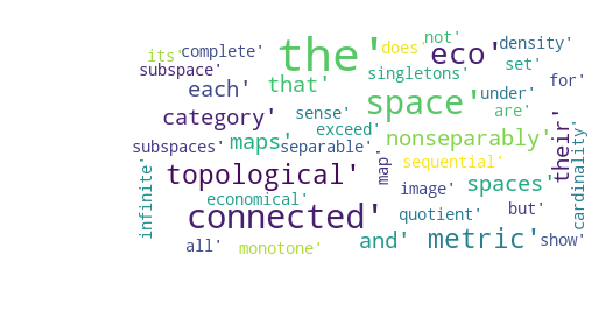

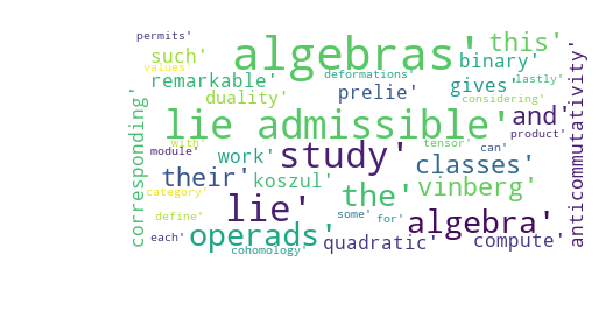

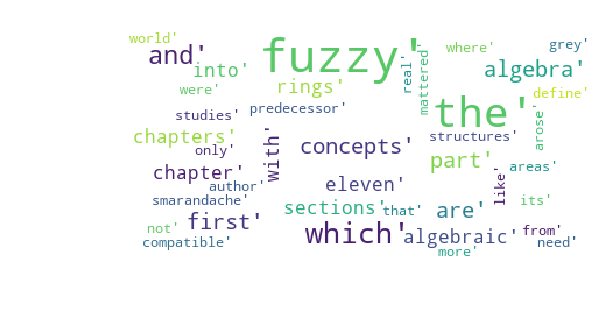

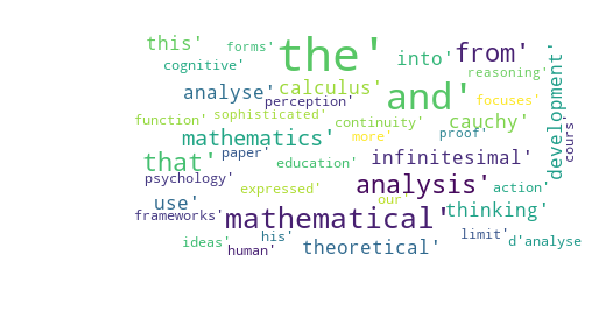

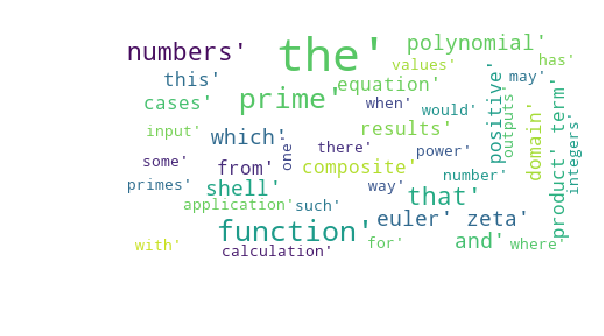

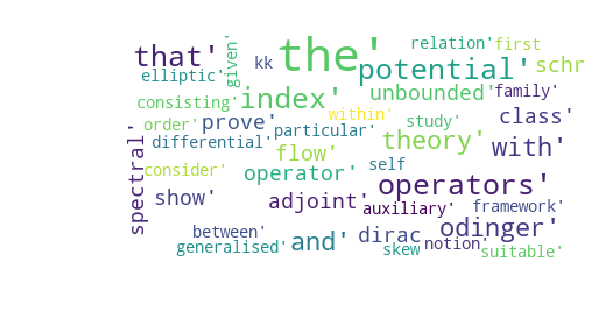

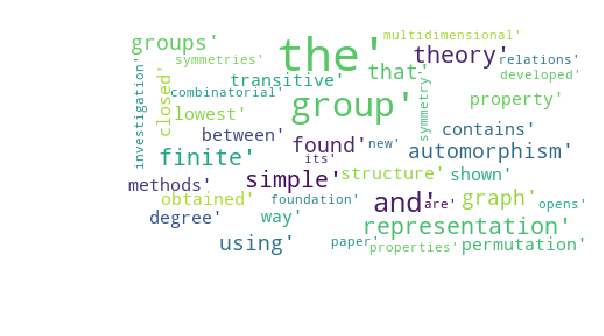

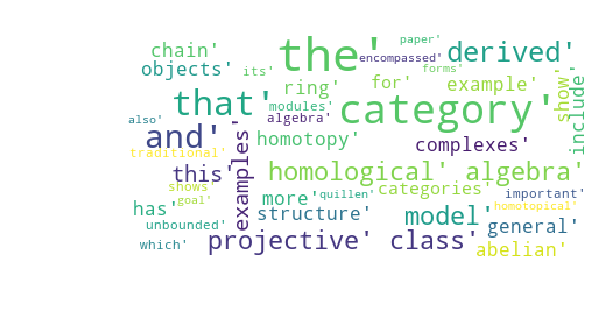

In [45]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud

mpl.rcParams['figure.figsize']=(6.0,6.0)    #(6.0,4.0)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size']=40              #10 
mpl.rcParams['figure.subplot.bottom']=.1 

for x in closest:
#stopwords = set(STOPWORDS)
 data = tokenize_only(summaries[x])

 wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.figure(1)
 plt.imshow(wordcloud)
 plt.axis('off')
 plt.show()


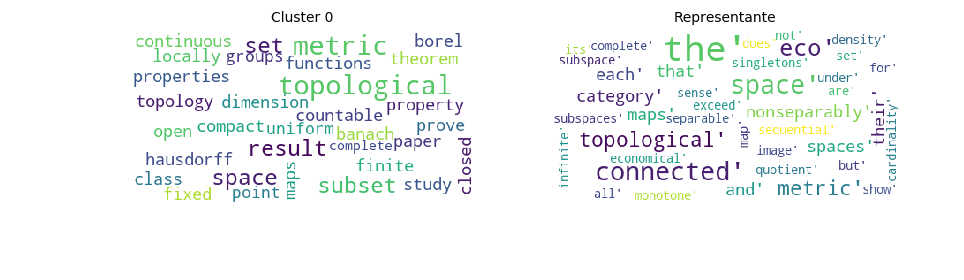

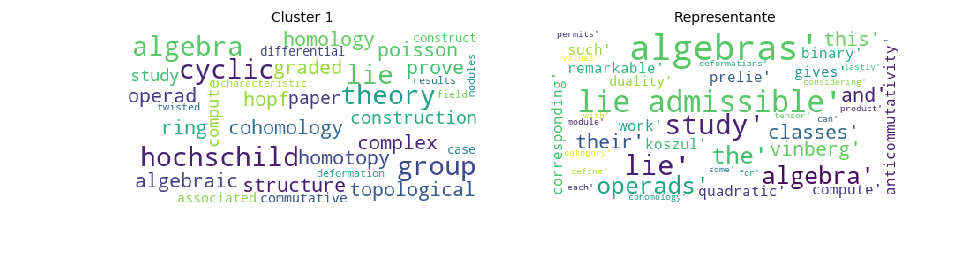

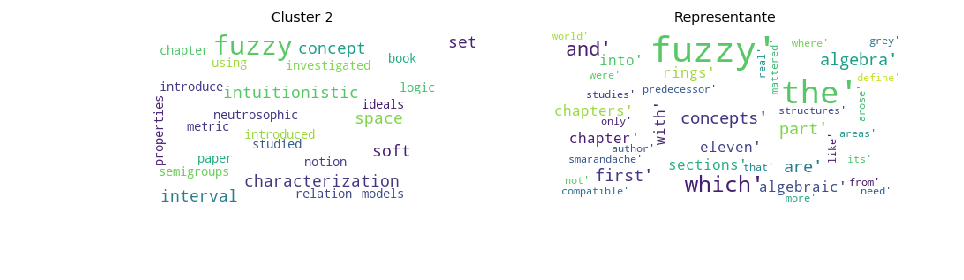

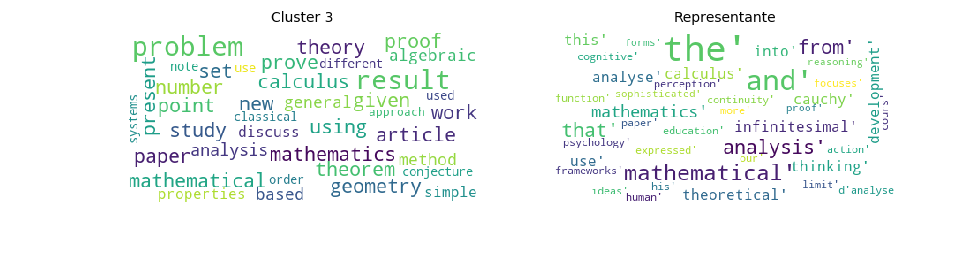

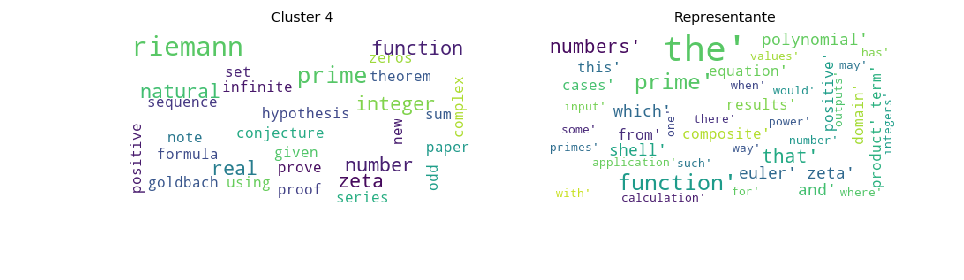

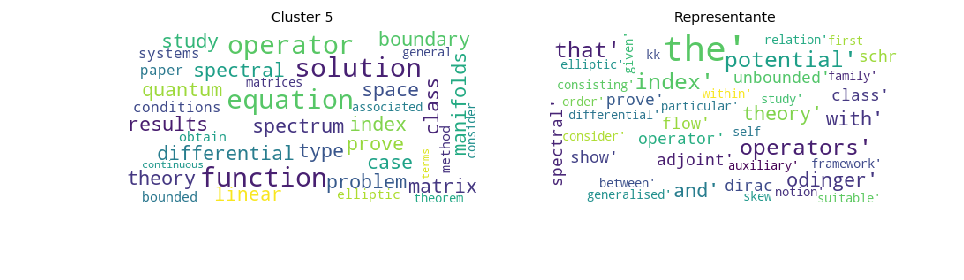

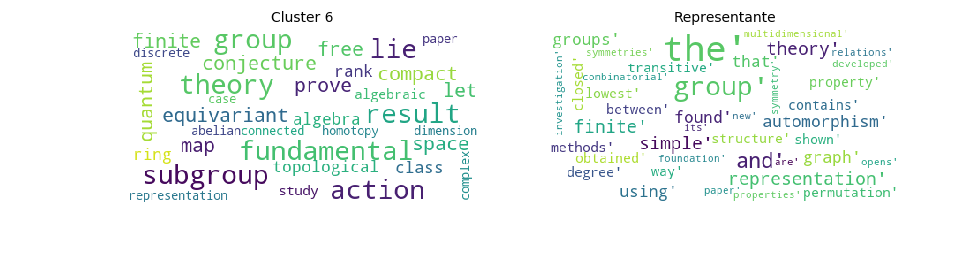

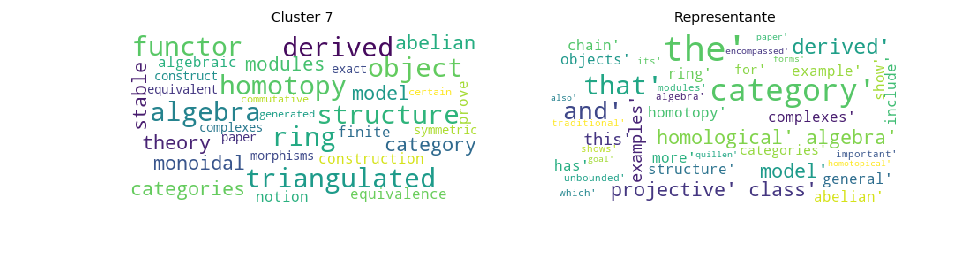

In [55]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud

mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size']=40              #10 
mpl.rcParams['figure.subplot.bottom']=.1 

for i in range(num_clusters):


 data=""
 for ind in order_centroids[i, :40]:
  data = data + " " + str(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])

 wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=30, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.subplot(1, 2, 1)
 plt.title("Cluster %s" %i,fontsize=10)
 plt.imshow(wordcloud)
 plt.axis('off')
    
 x=closest[i]
 data = tokenize_only(summaries[x])

 wordcloud = WordCloud(
                          background_color='white',
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.subplot(1, 2, 2)
 plt.title("Representante",fontsize=10)
 plt.imshow(wordcloud)
 plt.axis('off')
 plt.show()


Como podemos ver, en la mayoria de los casos los artículos mas cercanos al centroide parecen ser buenos representantes de los clusters.